In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Exercises

### The end result of this exercise should be a Jupyter notebook named model.
### Use either the SAAS dataset or the store data and:

In [2]:
def clean_saas_df(df):
    # set datetime data type and sort
    df['Month_Invoiced']=pd.to_datetime(df['Month_Invoiced'])
    
    # set 'Date' column as index and sorted
    df = df.set_index("Month_Invoiced").sort_index()
    
    # feature engineering: added 'month' column using index
    df['month'] = df.index.month_name()
    
    # feature engineering: added 'year' column using index
    df['year'] = df.index.year
    
    # change datatypes
    df["year"]  = df["year"].astype('string')
    df["Customer_Id"]  = df["Customer_Id"].astype('string')
    df["Invoice_Id"]  = df["Invoice_Id"].astype('string')
    df["Subscription_Type"]  = df["Subscription_Type"].astype('string')
    
    # rename columns snake_case
    
    df.columns = (df.columns
                .str.replace(' ', '_', regex=True)
                .str.lower()
             )

    return df

In [3]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [4]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [5]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [6]:
saas_df = pd.read_csv('saas.csv')

In [7]:
saas_df = clean_saas_df(saas_df)

In [8]:
saas_df.head()

,customer_id,invoice_id,subscription_type,amount,month,year
Month_Invoiced,,,,,,
2014-01-31,1000000,5000000,0.0,0.0,January,2014
2014-01-31,1000001,5000001,2.0,10.0,January,2014
2014-01-31,1000002,5000002,0.0,0.0,January,2014
2014-01-31,1000003,5000003,0.0,0.0,January,2014
2014-01-31,1000004,5000004,1.0,5.0,January,2014


# 1. Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.

In [9]:
# split settings
train_size = int(len(saas_df) * .5)
validate_size = int(len(saas_df) * .3)
test_size = int(len(saas_df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = saas_df[: train_size]
validate = saas_df[train_size : validate_end_index]
test = saas_df[validate_end_index : ]

In [10]:
train = train.resample('M').sum()

In [11]:
train.head()

,amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


# 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

## a. Simple Average

In [12]:
items = round(train['amount'].mean(), 2)

yhat_df = pd.DataFrame({'amount': [items],
                           }, index = validate.index)

yhat_df.head(3)

,amount
Month_Invoiced,
2015-10-31,44547.27
2015-10-31,44547.27
2015-10-31,44547.27


In [13]:
train.columns

Index(['amount'], dtype='object')

In [14]:
yhat_df['amount']

Month_Invoiced
2015-10-31    44547.27
2015-10-31    44547.27
2015-10-31    44547.27
2015-10-31    44547.27
2015-10-31    44547.27
                ...   
2017-01-31    44547.27
2017-01-31    44547.27
2017-01-31    44547.27
2017-01-31    44547.27
2017-01-31    44547.27
Name: amount, Length: 237137, dtype: float64

amount -- RMSE: 44544


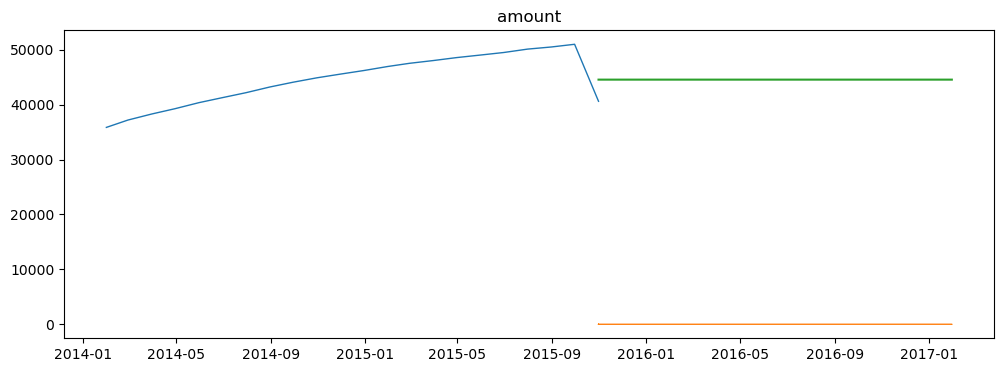

In [15]:
for col in train.columns:
    plot_and_eval(col)

In [16]:
for col in train.columns:
    print(col)

amount


In [17]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,simple_average,amount,44544.0


## b. Moving Average

In [18]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 3
items = round(train['amount'].rolling(period).mean().iloc[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': [items],
                           }, index = validate.index)
yhat_df.head(2)

,amount
Month_Invoiced,
2015-10-31,47361.67
2015-10-31,47361.67


amount -- RMSE: 47358


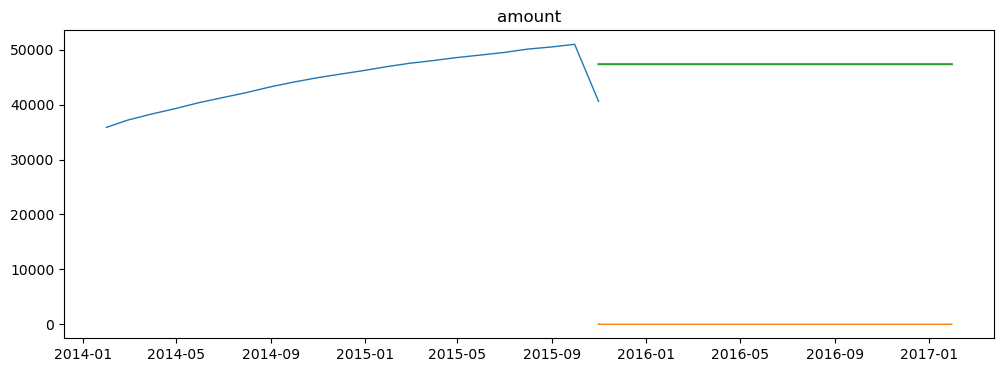

In [19]:
for col in train.columns:
    plot_and_eval(col)

In [20]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3M moving average', 
                             target_var = col)
eval_df

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,simple_average,amount,44544.0
1,3M moving average,amount,47358.0


In [21]:
periods = [1, 2, 6, 9, 12, 18]

for p in periods:
    items = round(train['amount'].rolling(p).mean().iloc[-1], 2)

    yhat_df = pd.DataFrame({'amount': [items],
                           }, index = validate.index)

    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [22]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,44544.0
1,3M moving average,amount,47358.0
2,1M moving average,amount,40602.0
3,2M moving average,amount,45792.0
4,6M moving average,amount,48447.0
5,9M moving average,amount,48308.0
6,12M moving average,amount,47789.0
7,18M moving average,amount,46077.0


In [23]:
# get the min rmse for each variable

min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
2,1M moving average,amount,40602.0


In [24]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

amount 



ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

## c. Holt's Linear Trend Model

In [25]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_trend = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

amount -- RMSE: 58905


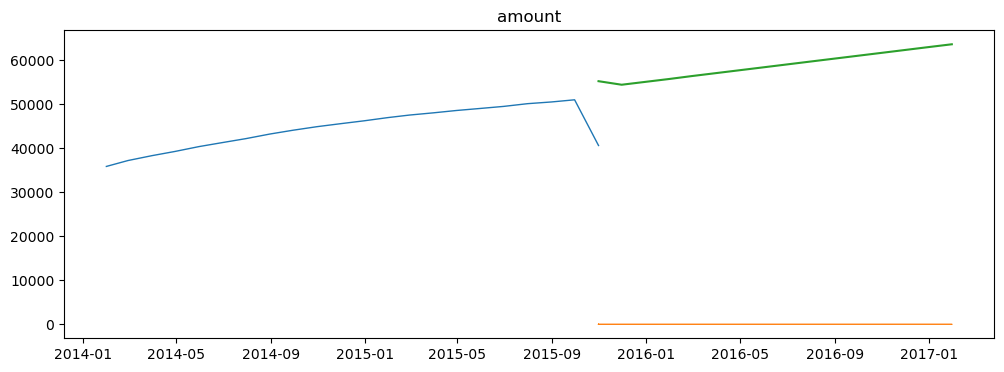

In [26]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1631977078.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


In [28]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,44544.0
1,3M moving average,amount,47358.0
2,1M moving average,amount,40602.0
3,2M moving average,amount,45792.0
4,6M moving average,amount,48447.0
5,9M moving average,amount,48308.0
6,12M moving average,amount,47789.0
7,18M moving average,amount,46077.0
8,Holts,amount,58905.0


## d. Based on previous year/month/etc., this is up to you.

### - Resample By Month
### - Predict based on previous year

```python
saas_df = pd.read_csv('saas.csv')
saas_df = clean_saas_df(saas_df)
```

In [30]:
# changing 'amount' column to float16
saas_df['amount']=saas_df['amount'].astype('float16')

In [31]:
train = saas_df[:'2015']
validate = saas_df['2016']
test = saas_df['2017']

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/3849541387.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  validate = saas_df['2016']
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/3849541387.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = saas_df['2017']


In [32]:
train.isnull().sum()

customer_id          0
invoice_id           0
subscription_type    0
amount               0
month                0
year                 0
dtype: int64

In [33]:
train.dtypes

customer_id           string
invoice_id            string
subscription_type     string
amount               float16
month                 object
year                  string
dtype: object

In [36]:
yhat_df = train['2015']['amount'] + train['amount'].diff(365).mean()

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/2577148869.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  yhat_df = train['2015']['amount'] + train['amount'].diff(365).mean()


In [37]:
yhat_df

Month_Invoiced
2015-01-31    -0.000093
2015-01-31    10.000000
2015-01-31    -0.000093
2015-01-31     5.000000
2015-01-31    10.000000
                ...    
2015-12-31    -0.000093
2015-12-31    -0.000093
2015-12-31    -0.000093
2015-12-31    -0.000093
2015-12-31    -0.000093
Name: amount, Length: 204352, dtype: float16

# Last Observed Value

In [40]:
# Predict sales using previous cycle method
yhat_df['pred_sales'] = train['2015']['amount'].shift(12)

print(yhat_df)

Month_Invoiced
2015-01-31 00:00:00                                            -0.000093
2015-01-31 00:00:00                                                 10.0
2015-01-31 00:00:00                                            -0.000093
2015-01-31 00:00:00                                                  5.0
2015-01-31 00:00:00                                                 10.0
                                             ...                        
2015-12-31 00:00:00                                            -0.000093
2015-12-31 00:00:00                                            -0.000093
2015-12-31 00:00:00                                            -0.000093
2015-12-31 00:00:00                                            -0.000093
pred_sales             Month_Invoiced
2015-01-31    NaN
2015-01-31   ...
Name: amount, Length: 204353, dtype: object


/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_3398/1905686494.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  yhat_df['pred_sales'] = train['2015']['amount'].shift(12)


In [41]:
yhat_df

Month_Invoiced
2015-01-31 00:00:00                                            -0.000093
2015-01-31 00:00:00                                                 10.0
2015-01-31 00:00:00                                            -0.000093
2015-01-31 00:00:00                                                  5.0
2015-01-31 00:00:00                                                 10.0
                                             ...                        
2015-12-31 00:00:00                                            -0.000093
2015-12-31 00:00:00                                            -0.000093
2015-12-31 00:00:00                                            -0.000093
2015-12-31 00:00:00                                            -0.000093
pred_sales             Month_Invoiced
2015-01-31    NaN
2015-01-31   ...
Name: amount, Length: 204353, dtype: object

In [ ]:
pd.concat([yhat_df.head(1), validate.head(1)])

In [ ]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [ ]:
saas_df.head()

```python
# Predict sales using previous cycle method
saas_df['pred_sales'] = saas_df['sales'].shift(12)

print(df_monthly)
```

# Bonus

### Using the store data:

## 1. Predict 2018 total monthly sales for a single store and/or item by creating a model.

## 2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). The upper and lower bounds of the predictions are auto generated when using the facebook prophet model, or you could calculate your own using, for example, bollinger bands.

## 3. Plot the 2018 monthly sales predictions.